CIFAR-10 Classifier Using CNN in PyTorch

In [1]:
# Importing Libraries
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline

Downloading, Loading and Normalising CIFAR-10

In [2]:
# This is the two-step process used to prepare the Data for use with the convolutional neural network.
# First step is to convert Python Image Library (PIL) format to PyTorch tensors.

# Second step is used to normalize the data by specifying a mean and standard deviation for each of the three channels.

# Normalize the train set 
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])


# Normalize the test set 
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=32,
                                         shuffle=False, num_workers=2)

#classes for CIFAR10
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']



Files already downloaded and verified
Files already downloaded and verified


The CIFAR-10 data set is composed of 60,000 32x32 colour images, 6,000 images per class, so 10 categories in total. The training set is made up of 50,000 images, while the remaining 10,000 make up the testing set.

In [3]:
#For given batchsize length of trainloader: 50000 / batchsize
print('Training Loader : ',len(trainloader)) 
#For the given batchsize the length of testloader: 10000 / batchsize
print('Test Loader :', len(testloader))
#Number of classes
print('Length of Classes: ', len(classes))

Training Loader :  1563
Test Loader : 313
Length of Classes:  10


images shape on batch size = torch.Size([32, 3, 32, 32])
labels shape on batch size = torch.Size([32])
0 : plane
1 : car
2 : bird
3 : cat
4 : deer
5 : dog
6 : frog
7 : horse
8 : ship
9 : truck

Images:


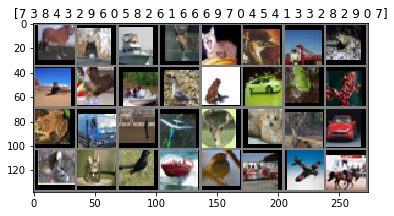

Labels corresponding to images:

horse ------   cat ------  ship ------  deer ------   cat ------  bird ------ truck ------  frog ------ plane ------   dog ------  ship ------  bird ------  frog ------   car ------  frog ------  frog ------  frog ------ truck ------ horse ------ plane ------  deer ------   dog ------  deer ------   car ------   cat ------   cat ------  bird ------  ship ------  bird ------ truck ------ plane ------ horse


In [4]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

print('images shape on batch size = {}'.format(images.size()))
print('labels shape on batch size = {}'.format(labels.size()))
for i in range(len(classes)):
    print(i,':',classes[i])
# show images
print('\nImages:')
plt.title(labels.numpy())
imshow(torchvision.utils.make_grid(images))

#print labels
print('Labels corresponding to images:\n')
print(' ------ '.join('%5s' % classes[labels[j]] for j in range(len(labels))))

**CREATE CNN CLASS TO CLASSIFY CIFAR10**

In [5]:
# Create a neural net class
class CNN(nn.Module):
    """CNN Model for CIFAR10 classifier """

    def __init__(self):
        """CNN Builder."""
        super(CNN, self).__init__()

        self.conv_layer = nn.Sequential(

            # Conv Layer block 1
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(p=0.2),

            # Conv Layer block 2
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(p=0.2),

            # Conv Layer block 3
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )


        self.fc_layer = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(4096, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.2),
            nn.Linear(512, 10)
        )


    def forward(self, x):
        """Perform forward."""
        
        # conv layers
        x = self.conv_layer(x)
        
        # flatten
        x = x.view(x.size(0), -1)
        
        # fc layer
        x = self.fc_layer(x)

        return F.log_softmax(x, dim=1)

In [6]:
def train(model, device, trainloader, optimizer, epoch):
    # Set the model to training mode
    model.train()
    correct = total = 0
    # Process the images in batches
    for epoch in range(epoch):
        train_loss = 0
        
        for i, data in enumerate(trainloader, 0):
            # Use the CPU or GPU as appropriate
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Reset the optimizer
            optimizer.zero_grad()

            # Push the data forward through the model layers
            output = model(inputs)
            
            # Get the loss
            loss = criterion(output, labels)        

            # Backpropagate
            loss.backward()
            optimizer.step()

            # Keep a running total
            train_loss += loss.item()

            # Calculate accuracy 
            _, predicted = torch.max(output.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            accuracy = 100 * ( correct / total )

            if i % len(trainloader) == 0:    # print every 100 mini-batches
                print('Epoch: {}|loss: {:.10f} |Training Accuracy: {:.3f}%'.format(epoch + 1, train_loss / 100, accuracy))
                trainloss_arr.append(train_loss/100)
                train_accuracy.append(accuracy)
                train_loss = 0
                test(model,device,testloader,epoch = 1)
                
    print("TRAINING AND TEST COMPLETED!!")


In [7]:
def test(model, device, testloader,epoch):
    # Set the model to training mode
    model.eval()
    total = 0
    correct = 0
    # Process the images in batches
    for epoch in range(1):
        test_loss = 0
        
        with torch.no_grad():
            for i, data in enumerate(testloader, 0):
                # Use the CPU or GPU as appropriate
                inputs, labels = data
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Push the data forward through the model layers
                output = model(inputs)
                
                # Get the loss
                loss = criterion(output, labels)        

                # Keep a running total
                test_loss += loss.item()

                # Calculate accuracy 
                _, predicted = torch.max(output.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                accuracy = 100 * ( correct / total )

                if i % len(testloader) == 0:    # print every 100 mini-batches
                  #  print('Test loss: {:.10f} |Test Accuracy: {:.3f}%'.format(test_loss / len(testloader), accuracy))
                   # testloss_arr.append(test_loss/len(testloader))
                    #test_accuracy.append(accuracy)
                    test_loss = 0
            testloss_arr.append(test_loss/10000)
            test_accuracy.append(accuracy)
            print('Test loss: {:.10f} |Test Accuracy: {:.3f}%'.format(test_loss/10000, accuracy))



In [8]:
import torch.optim as optim

trainloss_arr = []
testloss_arr = []

test_accuracy = []
train_accuracy = []

device = "cpu"
if (torch.cuda.is_available()):
    # if GPU available, use cuda (on a cpu, training will take a considerable length of time!)
    device = "cuda"

# Create an instance of the model class and allocate it to the device
model = CNN().to(device)

print(model)


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

CNN(
  (conv_layer): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Dropout2d(p=0.2)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (13): Dropout2d(p=0.2)
    (14): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
 

In [9]:
train(model, device, trainloader, optimizer, epoch=100)


Epoch: 1|loss: 0.0000461002 |Training Accuracy: 6.250%
Test loss: 0.0718514465 |Test Accuracy: 10.000%
Epoch: 2|loss: 0.0000318143 |Training Accuracy: 29.217%
Test loss: 0.0496263045 |Test Accuracy: 40.680%
Epoch: 3|loss: 0.0000291670 |Training Accuracy: 37.064%
Test loss: 0.0416253829 |Test Accuracy: 50.610%
Epoch: 4|loss: 0.0000275831 |Training Accuracy: 42.022%
Test loss: 0.0390609197 |Test Accuracy: 54.570%
Epoch: 5|loss: 0.0000208864 |Training Accuracy: 45.828%
Test loss: 0.0328667540 |Test Accuracy: 62.100%
Epoch: 6|loss: 0.0000160871 |Training Accuracy: 48.997%
Test loss: 0.0296846002 |Test Accuracy: 66.300%
Epoch: 7|loss: 0.0000157359 |Training Accuracy: 51.735%
Test loss: 0.0290498366 |Test Accuracy: 65.940%
Epoch: 8|loss: 0.0000185104 |Training Accuracy: 54.014%
Test loss: 0.0258994738 |Test Accuracy: 70.300%
Epoch: 9|loss: 0.0000143368 |Training Accuracy: 55.972%
Test loss: 0.0277342017 |Test Accuracy: 68.790%
Epoch: 10|loss: 0.0000160247 |Training Accuracy: 57.709%
Test los

Test loss: 0.0215400910 |Test Accuracy: 86.040%
Epoch: 80|loss: 0.0000001613 |Training Accuracy: 88.140%
Test loss: 0.0232374034 |Test Accuracy: 86.030%
Epoch: 81|loss: 0.0000009237 |Training Accuracy: 88.267%
Test loss: 0.0213146764 |Test Accuracy: 86.620%
Epoch: 82|loss: 0.0000010988 |Training Accuracy: 88.391%
Test loss: 0.0222394424 |Test Accuracy: 85.750%
Epoch: 83|loss: 0.0000014290 |Training Accuracy: 88.511%
Test loss: 0.0209535152 |Test Accuracy: 86.830%
Epoch: 84|loss: 0.0000058878 |Training Accuracy: 88.629%
Test loss: 0.0217518834 |Test Accuracy: 86.280%
Epoch: 85|loss: 0.0000007287 |Training Accuracy: 88.746%
Test loss: 0.0223551953 |Test Accuracy: 86.380%
Epoch: 86|loss: 0.0000041561 |Training Accuracy: 88.859%
Test loss: 0.0207339718 |Test Accuracy: 87.320%
Epoch: 87|loss: 0.0000006129 |Training Accuracy: 88.972%
Test loss: 0.0207614633 |Test Accuracy: 86.900%
Epoch: 88|loss: 0.0000001003 |Training Accuracy: 89.080%
Test loss: 0.0214665729 |Test Accuracy: 87.340%
Epoch: 

In [17]:
#Save the model
path = './cifar10.pth'
torch.save(model.state_dict(),path)

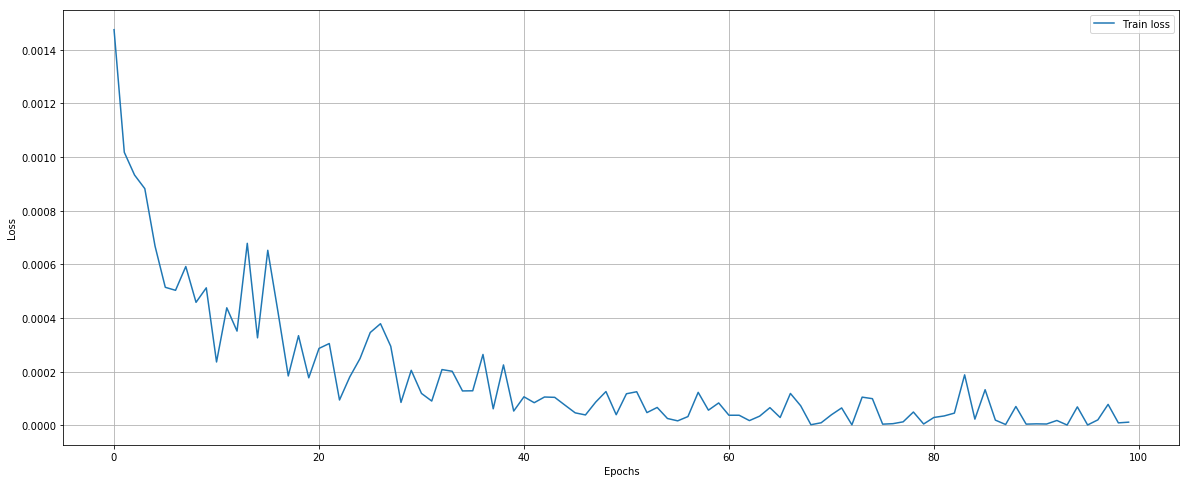

In [10]:
#Loss Plot
plt.figure(figsize=(20, 8))
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(trainloss_arr,label='Train loss')
# plt.plot(testloss_arr,label='Test loss')
plt.legend()
plt.grid(True)
plt.show()

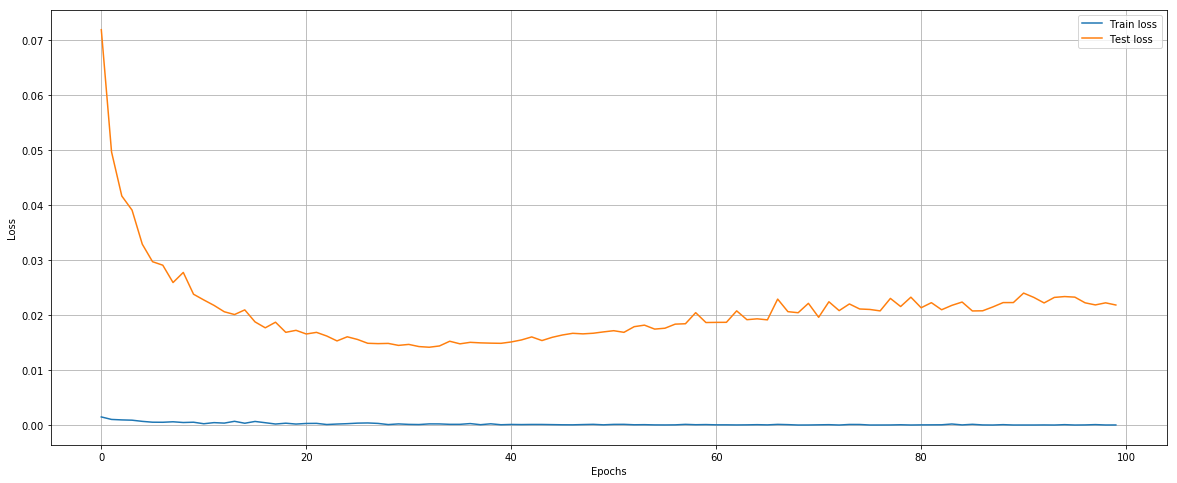

In [11]:
#Loss plot of Test set and Train set
plt.figure(figsize=(20, 8))
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(trainloss_arr,label='Train loss')
plt.plot(testloss_arr,label='Test loss')
plt.legend()
plt.grid(True)
plt.show()

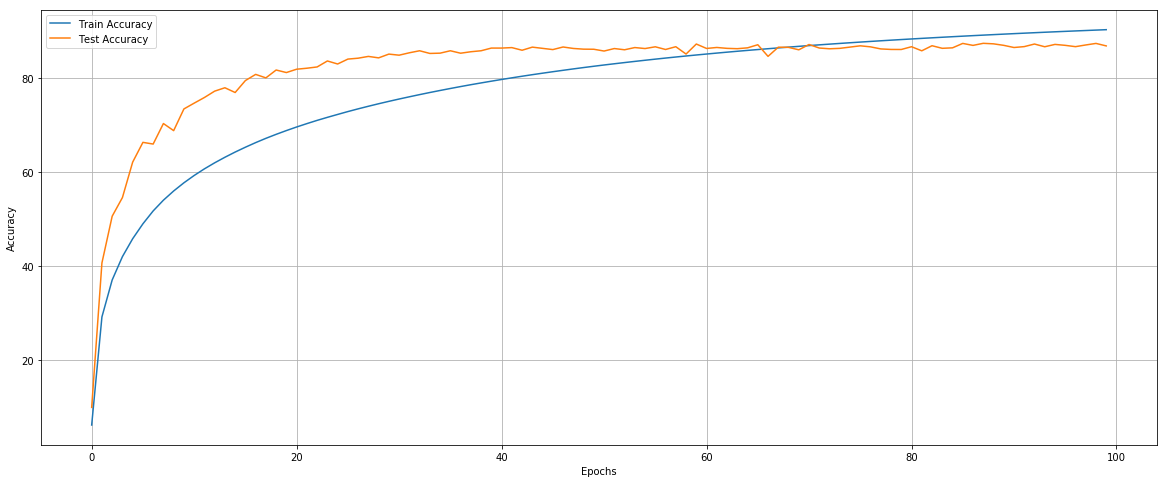

In [12]:
#Accuracy plot of test and Train set
plt.figure(figsize=(20, 8))
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(train_accuracy,label='Train Accuracy')
plt.plot(test_accuracy,label='Test Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [15]:
# Accuracy of each of the classes
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 87 %
Accuracy of   car : 95 %
Accuracy of  bird : 77 %
Accuracy of   cat : 72 %
Accuracy of  deer : 84 %
Accuracy of   dog : 83 %
Accuracy of  frog : 90 %
Accuracy of horse : 90 %
Accuracy of  ship : 92 %
Accuracy of truck : 97 %
